# Kalman Filter Data Assimilation Example

## Introduction

This is the example presented at the ESSA [Social Simulation Conference (SSC)](http://www.sim2017.com/) on 26th September 2017 in Dublin. It shows how to use an Ensemble Kalman Filter (EnKF) to assimilate data into a simple agent-based model. I can't take any credit for the code, it was written entirely by Alice Tapper and [Jon Ward](http://www1.maths.leeds.ac.uk/~jaward/); I've only adapted and commented it.

The slides explaining the work are available on the [Simulating Urban Flows
website](http://surf.leeds.ac.uk/p/2017-09-26-essa-da.html) and the full paper is available <a href="http://surf.leeds.ac.uk/p/2017-09-26-essa-da.pdf">here</a>.

The code below makes use of the [workingcameras.py](./workingcameras.py) model. This is a simple model in which agents start at one end of a hypothetical street and walk towards the other end. Some of them are able to leave the street half way along. There are hypotehtical cameras at each end of the street that count how many people enter and leave, but we don't know how many leave at the midpoint. The purpose of the EnKF is to take the latest counts from the second camera and use this to estimate the real number of people currently in the street.

This example begins with running one step of the process to demonstrate how it works before running the whole process a number of times.

Please note that you will need the packages `pandas` and `pillow`.


## Initialisation

Load the required packages

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import workingcameras as cam # The model
np.random.seed(3)

%matplotlib inline

## Generate hypothetical 'truth'

First we generate the 'true' data. We will pretent that this represents the real world system. Use 7200 minutes for no real reason, and choose a probability of agents leaving the street at the midpoint (the 'bleed out rate') drawn from a normal distribution of 0.5, standard deviation 0.1. Start with 600 agents

In [2]:
bleedoutrate_true = np.random.normal(0.5, scale=0.1)
print("Bleedout rate is: {}".format(bleedoutrate_true))
truth = cam.runProgramTrue(bleedoutrate_true, 7200, 600) 

Bleedout rate is: 0.6788628473430318
finished saving camera counts


## Create the ensemble

The 'ensemble' is the group of models that we run simultaneously. For now use an ensemble of size 30 for speed, but ultimately maybe 100 will work better.

Initialise the ensemble drawing the bleed out rate from the prior normal distribution,
mean 0.5 and SD 0.1.

In [4]:
initial = []

for i in range(30):
    bleedoutrate = np.random.normal(0.5, scale=0.1)
    result = cam.runProgram(bleedoutrate, 61, 600)
    initial.append(result)

initial = np.array(initial)

finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts
finished saving camera counts


Look at the spread in bleedoutrates across the ensemble

In [5]:
initial[:, -3] 

array([ 0.54365099,  0.50964975,  0.31365073,  0.47226118,  0.4645241 ,
        0.49172585,  0.43729993,  0.49561818,  0.4522782 ,  0.36861352,
        0.58846224,  0.5881318 ,  0.67095731,  0.50500336,  0.45953226,
        0.44546401,  0.34535227,  0.59823674,  0.38989324,  0.38149535,
        0.47943501,  0.64861484,  0.52367163,  0.39762149,  0.42870068,
        0.5625245 ,  0.48394866,  0.42311636,  0.47699693,  0.57450563])

## Forecast Step

In the 'forecast' step, the current (estimated) model state is fed into the model, and the model plays forward until the next observation time (1 hour in this case). This generates a forecast. 

The ensemble forecast mean will give an estimated forecast of the true state, while the covariance of the ensemble forecast states provides a measure of its uncertainty.

Now step each model in the ensemble by running them forward for an hour

In [6]:
forecasts = []

for i in range(30):
    prediction = cam.runForecast(61, 600, initial[i], 0, 0, 0, steps=60)
    forecasts.append(prediction)
    
forecasts = np.array(forecasts)


70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished saving camera counts
70
80
90
100
110
120
finished s

### Generate the covariance matrix

We now generate the forecast covariance matrix. This is used to provide a measure of the uncertainty of the ensemble forecasts.

The covariance matrix is an N x N matrix, where:
 - N = M agents locations and route info + bleedoutrate + c_a counts + c_b counts,
 - i.e N = 2M + 3

We find the mean of the forecast ensemble, and find the error from the mean for each value

In [12]:
means = np.mean(forecasts, axis=0)
adjusted = forecasts - means
covariance = np.cov(adjusted.T)

The covariance[-1][-3] measures how the change in bleed out rate affects
the change in the c_b counts

In [18]:
print(covariance[-1][-3])

0.730948154486


## Data Assimilation Step

Upon receiving the actual observation from our 'truth' data, the ensemble forecasts are updated accordingly.  The updated values are called the ensemble analysis. As before, the ensemble analysis mean will give the best estimation of the true state, while the covariance of the ensemble analysis states provides a measure of its uncertainty.

Start by getting the next observation from our truth data (these are counts from the two cameras).

### Prepare virtual and 'real' observations

In [21]:
observation = [truth[-2][2], truth[-1][2]]
print(observation)

[99, 73]


Then we create the virtual observations by assuming additive Gaussian noise (in the real world sensors will never produce 100% accurate estimates of the state of the world, so we assume that our measurements contain some noise).

In [24]:
virtualobs = np.zeros((30,2))

for i in range(30):
    for j in range(2):
        virtualobs[i][j] = observation[j] + np.random.normal(0, 15)

print(virtualobs)

[[  91.25373948   58.6000573 ]
 [ 104.65942851   64.37937369]
 [  97.35818499   83.186074  ]
 [  86.16844247   68.49690888]
 [ 131.37224013   86.11428584]
 [  79.59695052   71.80388593]
 [ 107.46728277   91.50206567]
 [ 101.23479592   65.04126783]
 [  88.04210034   82.67592977]
 [ 103.69590561   65.25028113]
 [  96.163925     66.75702977]
 [ 109.86986487   62.65058984]
 [ 106.29621713   85.77278426]
 [ 106.29373989   60.48640224]
 [ 119.17488685   62.82680981]
 [ 105.39652612   61.6999781 ]
 [  72.83834624   76.38625399]
 [ 103.30552747   71.83838559]
 [ 103.14102746   63.27383668]
 [  87.93802744   70.47864852]
 [ 127.63915214   85.22221812]
 [  91.20012369   81.38069807]
 [  91.82453009   66.14108819]
 [ 111.88926012   65.12103032]
 [  73.86548049   59.40257949]
 [ 100.32622809   74.92011732]
 [ 117.62424777   62.25961304]
 [ 109.97198604   79.38950125]
 [  96.76479342   85.53765853]
 [ 106.38178354   60.0653727 ]]


### Kalman Gain Matrix

Code the matrix H, the forward model, which is just a transformation matrix changing the state vector into the same form as the observation vector

In [26]:
H = np.zeros((2, 2*600 + 3))

H[-1][-1] = 1
H[0][-2] = 1

Calculate the **Kalman gain matrix**. This is used to balance the impact of the new data on the model states as the real world state should be some combination of an imperfect model and the imperfect real world observations.

R contains the variance of the random errors (i.e 15^2)

In [31]:
P = covariance
R = np.array([[225, 0],[0, 225]])

tbi = np.dot(np.dot(H,P),H.T) + R # (tbi = 'to be inverted')

# We want to solve K tbi = P H.T to find K 
# rewrite to form tbi.T K.T = H P.T'''

LHS = tbi.T
RHS = np.dot(H,P.T)

Ktranspose = np.linalg.lstsq(LHS,RHS)

K = Ktranspose[0].T

### The ensemble analysis

Create the ensemble analysis

In [33]:
ens_analysis = []

for i in range(30):
    tbm = virtualobs[i] - np.dot(H,forecasts[i])
    adjust = forecasts[i] + np.dot(K,tbm)
    ens_analysis.append(adjust)

Average the ensemble analysis and find analysis covariance

In [53]:
ens_means = np.mean(ens_analysis, axis=0)

ens_error = ens_analysis - ens_means

ens_covariance = np.cov(ens_error.T)

That's it! We can now just repeat that process for as many iterations as we want to.

Finish by looking at the ensemble means.

{'boxes': [<matplotlib.lines.Line2D at 0x11bf91c50>],
 'caps': [<matplotlib.lines.Line2D at 0x11dfd5f98>,
 'fliers': [<matplotlib.lines.Line2D at 0x11dfe1d30>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11dfe1710>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11bf91e10>,
  <matplotlib.lines.Line2D at 0x11dfd5978>]}

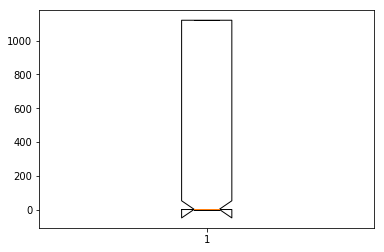

In [54]:
plt.boxplot(ens_means, notch=True)